In [62]:
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import math

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import MiniBatchKMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.utils import resample


The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


In [58]:
df_recipe=pl.read_csv("./data/raw/RAW_recipes.csv")

df_interaction=pl.read_csv("./data/raw/RAW_interactions.csv")

### The analysis combines the elbow method and the silhouette method to determine the optimal number of clusters (k) in a MiniBatchKMeans clustering.

#### The elbow method involves plotting the inertia (sum of squared distances of points to their cluster centers) as a function of k. The goal is to identify a point where the decrease in inertia slows significantly, forming an "elbow." This indicates that adding more clusters does not substantially improve the quality. However, this method can sometimes be ambiguous.

#### The silhouette score method complements this analysis by measuring how well-separated and compact the clusters are, with values ranging from -1 to 1. A score close to 1 indicates well-defined clusters, a score near 0 indicates overlapping clusters, and a negative score indicates poor clustering.

#### By combining these two criteria, a more robust choice of k is achieved. In practice, we prefer a k where the inertia begins to stabilize and the silhouette score is maximized. This ensures that the clusters are both compact and well-separated, making them easier to interpret and use later.

#### For the silhouette method, the calculations were performed using $\verb|sklearn.metrics.silhouette.score|$ 

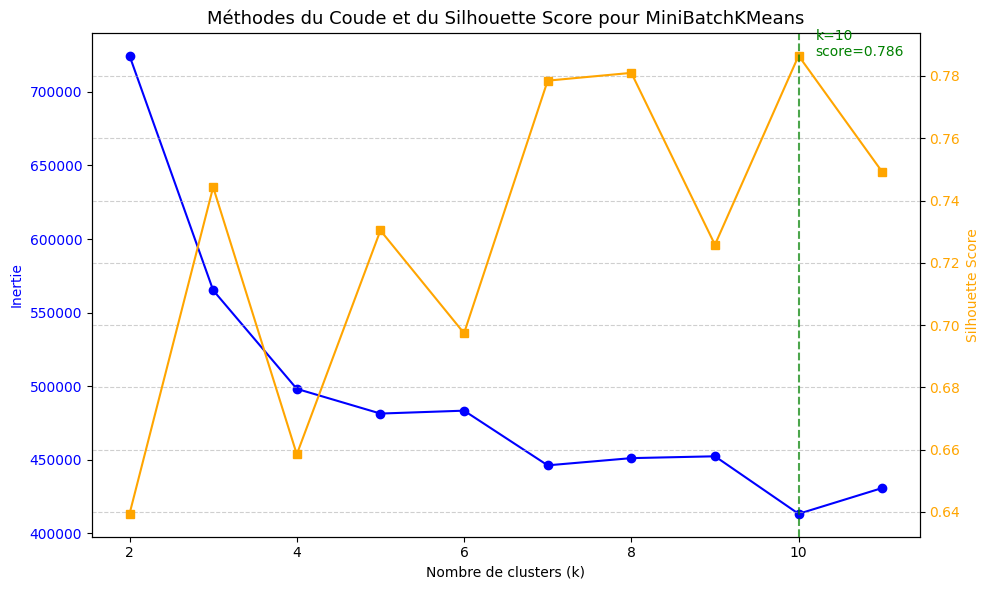

In [66]:
# les calculs par la methode de la silhouette ont déjà été réalisé 

# --- 1. Créer le DataFrame Polars ---
df_scores = pl.DataFrame({
    "k": [2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
    "inertie": [724608.3, 565130.2, 498131.1, 481338.3, 483306.3,
                446134.1, 451036.6, 452287.7, 413176.4, 430706.9],
    "silhouette": [0.6394, 0.7443, 0.6585, 0.7304, 0.6974,
                   0.7785, 0.7810, 0.7258, 0.7865, 0.7492]
})

# --- 2. Trouver automatiquement le meilleur k selon silhouette ---
best_row = df_scores.sort("silhouette", descending=True).row(0)
best_k, best_sil = best_row[0], best_row[2]

# --- 3. Visualisation combinée ---
fig, ax1 = plt.subplots(figsize=(10, 6))

# Axe 1 : inertie
ax1.plot(df_scores["k"], df_scores["inertie"], 'o-', color='blue', label="Inertie")
ax1.set_xlabel("Nombre de clusters (k)")
ax1.set_ylabel("Inertie", color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Axe 2 : silhouette
ax2 = ax1.twinx()
ax2.plot(df_scores["k"], df_scores["silhouette"], 's-', color='orange', label="Silhouette Score")
ax2.set_ylabel("Silhouette Score", color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# Titre et annotation du meilleur k
plt.title("Méthodes du Coude et du Silhouette Score pour MiniBatchKMeans", fontsize=13)
ax2.axvline(best_k, color='green', linestyle='--', alpha=0.7)
ax2.text(best_k + 0.2, best_sil, f"k={best_k}\nscore={best_sil:.3f}", color='green')

plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()



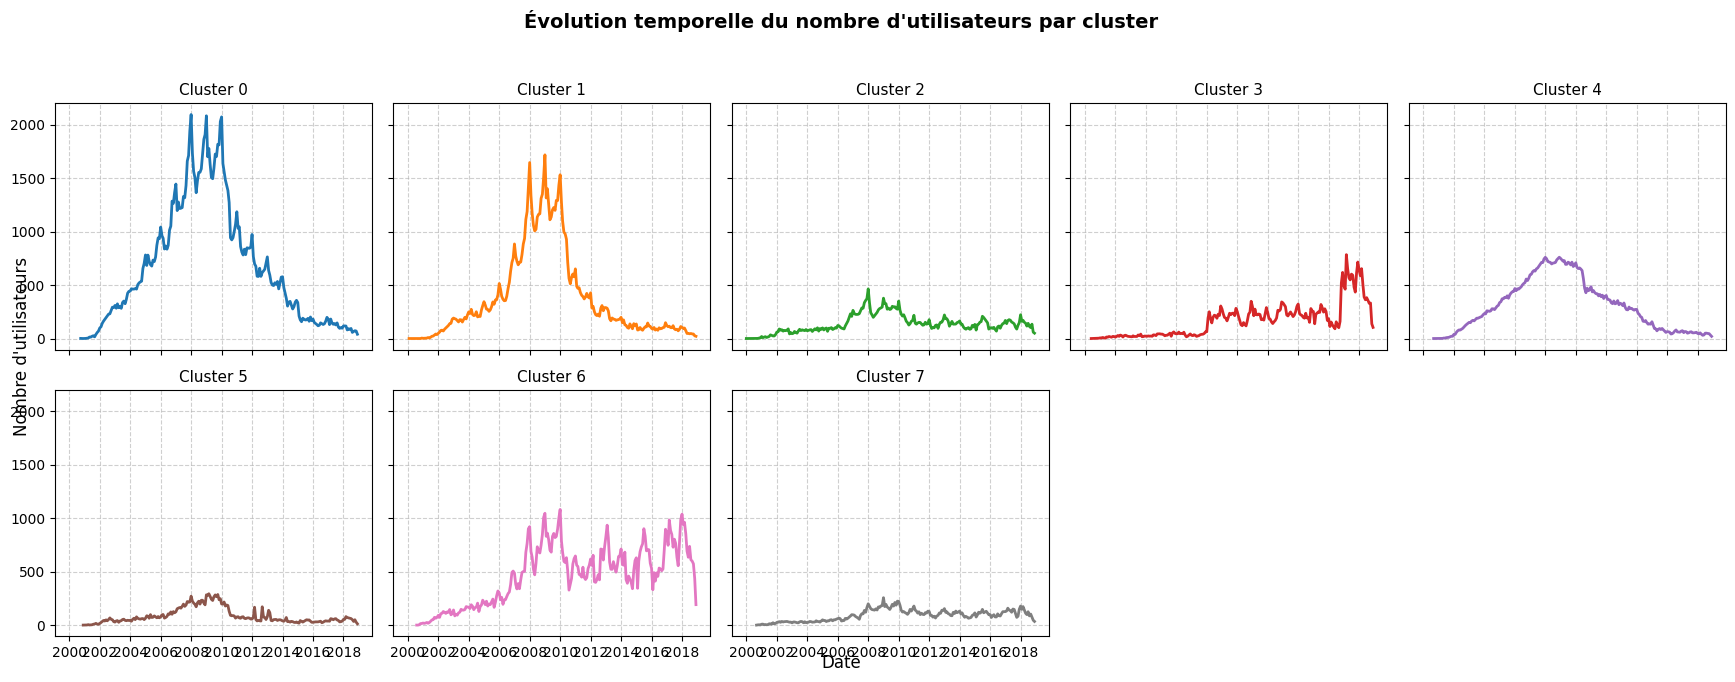

In [64]:
# 1 S'assurer que les clusters sont triés
unique_clusters = sorted(df_pandas["cluster"].unique())
n_clusters = len(unique_clusters)

# 2 Définir automatiquement le nombre de lignes / colonnes
cols = 5
rows = math.ceil(n_clusters / cols)

fig, axes = plt.subplots(rows, cols, figsize=(18, 3.5 * rows), sharex=True, sharey=True)
axes = axes.flatten()

# 3 Palette de couleurs
colors = plt.cm.tab10.colors

# 5 Tracer chaque cluster
for i, c in enumerate(unique_clusters):
    df_c = df_pandas[df_pandas["cluster"] == c].sort_values("period")
    axes[i].plot(df_c["period"], df_c["n_users"], color=colors[i % 10], linewidth=2)
    axes[i].set_title(f"Cluster {c}", fontsize=11)
    axes[i].grid(True, linestyle="--", alpha=0.6)

# 6 Supprimer les sous-graphiques vides (s'il y en a)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# 7 affichage des courbes
fig.suptitle("Évolution temporelle du nombre d'utilisateurs par cluster", fontsize=14, fontweight="bold")
fig.text(0.5, 0.04, "Date", ha="center", fontsize=12)
fig.text(0.04, 0.5, "Nombre d'utilisateurs", va="center", rotation="vertical", fontsize=12)
plt.tight_layout(rect=[0.03, 0.03, 1, 0.95])
plt.show()

#### It has been observed that, for the optimal K, some clusters are empty. Therefore, the distribution of users per cluster should first be analyzed to find a K that yields better results.

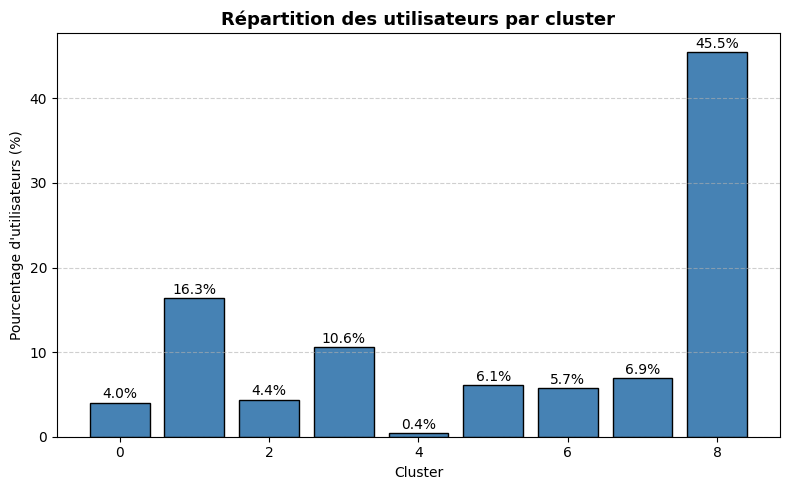

In [53]:
# 1 Comptage des utilisateurs par cluster
unique, counts = np.unique(labels_final, return_counts=True)

# 2 Conversion en pourcentage
total = counts.sum()
percentages = (counts / total) * 100

# 3 --- Visualisation ---
plt.figure(figsize=(8, 5))
plt.bar(unique, percentages, color="steelblue", edgecolor="black")

# 4 Ajouter les pourcentages au-dessus des barres
for i, pct in enumerate(percentages):
    plt.text(unique[i], pct + 0.5, f"{pct:.1f}%", ha="center", fontsize=10)

plt.title("Répartition des utilisateurs par cluster", fontsize=13, fontweight="bold")
plt.xlabel("Cluster")
plt.ylabel("Pourcentage d'utilisateurs (%)")
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


#### Only clusters representing more than 1% of users are retained, resulting in k=8

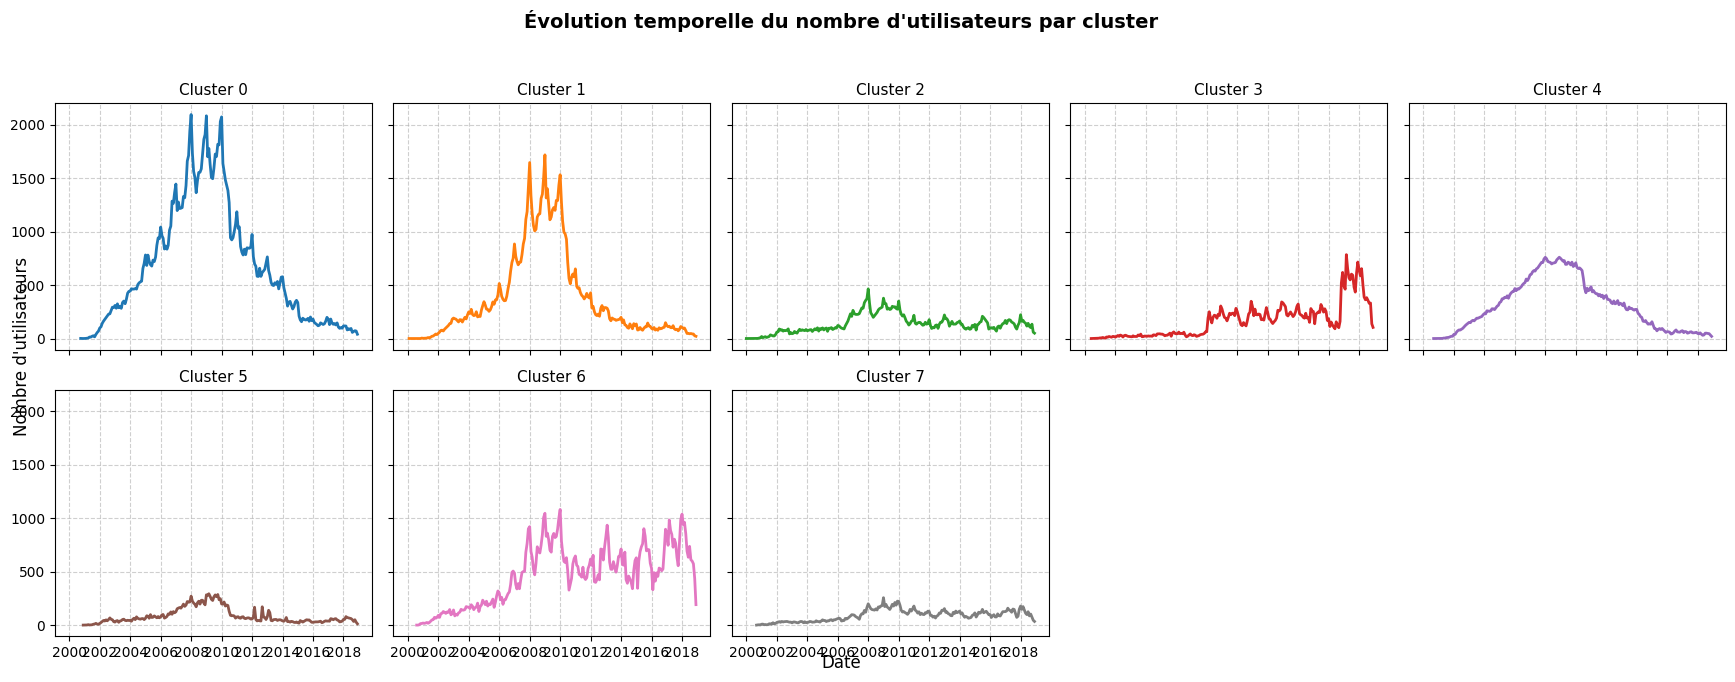

In [56]:
n_clusters = 8

# Définir automatiquement le nombre de lignes / colonnes
cols = 5
rows = math.ceil(n_clusters / cols)

fig, axes = plt.subplots(rows, cols, figsize=(18, 3.5 * rows), sharex=True, sharey=True)
axes = axes.flatten()

# Palette de couleurs
colors = plt.cm.tab10.colors

# Tracer chaque cluster
for i, c in enumerate(unique_clusters):
    df_c = df_pandas[df_pandas["cluster"] == c].sort_values("period")
    axes[i].plot(df_c["period"], df_c["n_users"], color=colors[i % 10], linewidth=2)
    axes[i].set_title(f"Cluster {c}", fontsize=11)
    axes[i].grid(True, linestyle="--", alpha=0.6)

# Supprimer les sous-graphiques vides (s'il y en a)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Ajustements généraux
fig.suptitle("Évolution temporelle du nombre d'utilisateurs par cluster", fontsize=14, fontweight="bold")
fig.text(0.5, 0.04, "Date", ha="center", fontsize=12)
fig.text(0.04, 0.5, "Nombre d'utilisateurs", va="center", rotation="vertical", fontsize=12)
plt.tight_layout(rect=[0.03, 0.03, 1, 0.95])
plt.show()

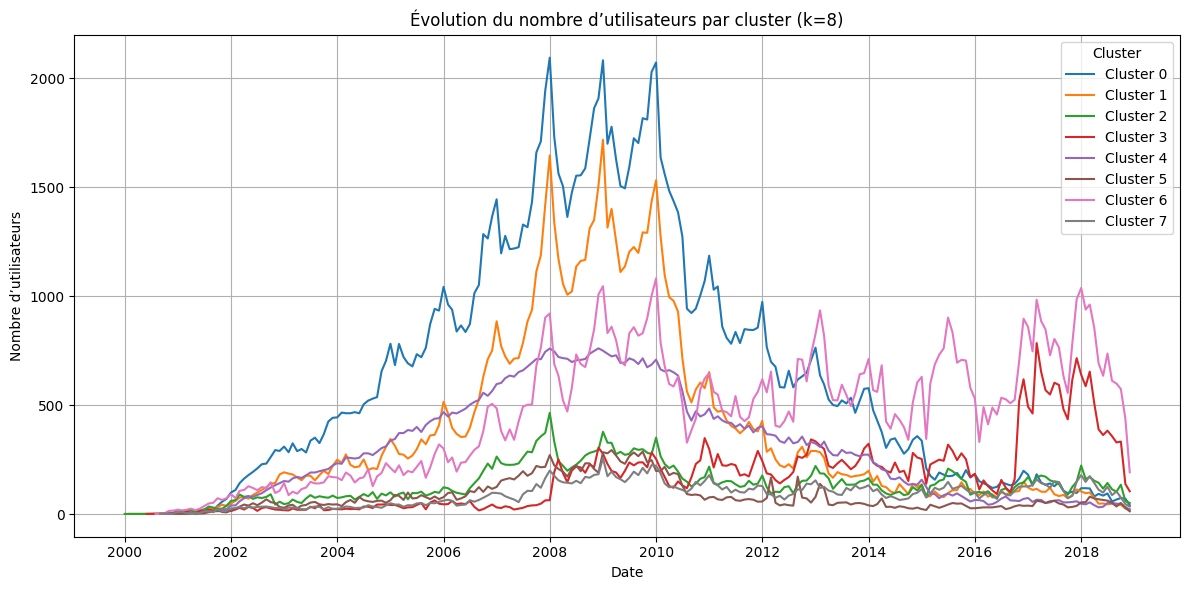

In [65]:
# --- 1. Appliquer clustering final avec le meilleur k ---
kmeans_final = MiniBatchKMeans(n_clusters=8, random_state=42, batch_size=512)
labels_final = kmeans_final.fit_predict(X_scaled)
user_features = user_features.with_columns(pl.Series("cluster", labels_final))

# --- 2. Joindre clusters aux données originales ---
df_clustered = df.join(user_features.select(["user_id", "cluster"]), on="user_id", how="left")

# --- 3. Regrouper par mois et cluster pour visualiser évolution ---
df_time = (
    df_clustered.group_by(["year", "month", "cluster"])
    .agg(pl.col("user_id").n_unique().alias("n_users"))
    .sort(["year", "month", "cluster"])
)


df_time = df_time.with_columns(
    (pl.datetime(df_time["year"], df_time["month"], 1)).alias("period")
)

# --- 4. Conversion pandas pour matplotlib ---
df_pandas = df_time.to_pandas()

# --- 5. Visualisation évolution temporelle ---
plt.figure(figsize=(12, 6))
for c in sorted(df_pandas["cluster"].unique()):
    df_c = df_pandas[df_pandas["cluster"] == c]
    plt.plot(df_c["period"], df_c["n_users"], marker="", label=f"Cluster {c}")

plt.title(f"Évolution du nombre d’utilisateurs par cluster (k={n_clusters})")
plt.xlabel("Date")
plt.ylabel("Nombre d’utilisateurs")
plt.legend(title="Cluster")
plt.grid(True)
plt.tight_layout()